<a href="https://colab.research.google.com/github/Gobihanath/DTect/blob/main/DTect_predictX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***DTect-predictX***  - Prediction Model for DTect Signature Verification System
---



---





### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import cv2

input_shape = (256,256, 3)

Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define Input Parameters

In [3]:
Image_Width = 256
Image_Height = 256
Image_Size = (Image_Width, Image_Height)
Image_Channel = 3
batch_size=128

## Loading Data

In [4]:
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Dataset/Dtect | Dataset | New",
    seed=123,         #If you want to ensure that the shuffling of your dataset is the same across different runs, you can keep the seed value constant. If you don't care about reproducibility, you can omit the seed parameter or use a different value for each run.
    shuffle=True,
    image_size=Image_Size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5001 files belonging to 10 classes.


In [5]:
class_names = data_set.class_names
class_names

['Person 1',
 'Person 10',
 'Person 2',
 'Person 3',
 'Person 4',
 'Person 5',
 'Person 6',
 'Person 7',
 'Person 8',
 'Person 9']

## Dataset Partition

In [6]:
def get_dataset_partitions_tf(data_set, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(data_set)

    if shuffle:
        data_set = data_set.shuffle(shuffle_size, seed=123)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = data_set.take(train_size)
    val_ds = data_set.skip(train_size).take(val_size)
    test_ds = data_set.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data_set)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

32
4
4


## Visualizing some Signature image samples from dataset

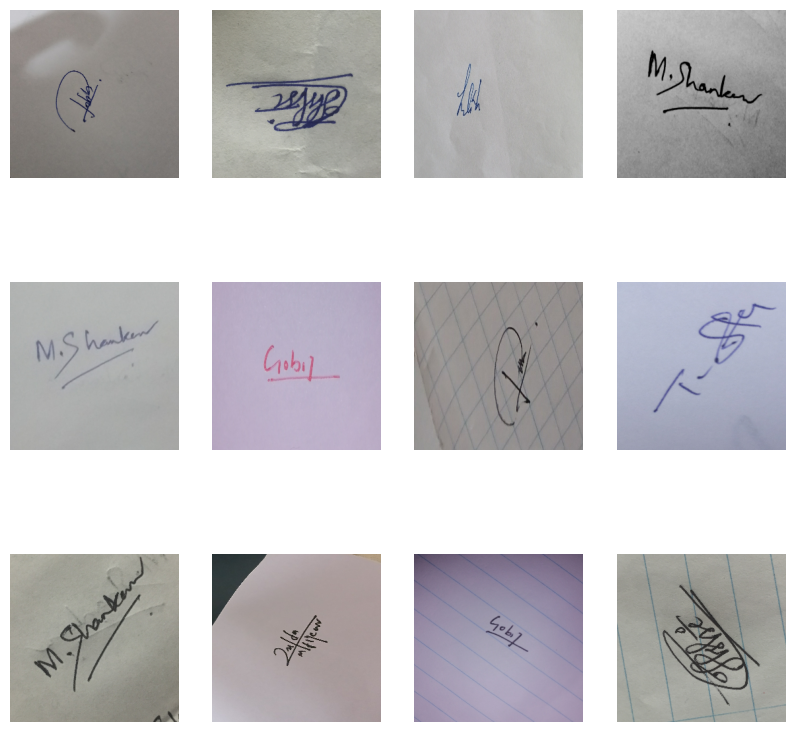

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data_set.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

## Developing a Sequential CNN model

In [8]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=input_shape))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       7

In [9]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Setting an accuracy threshold for early stopping

In [10]:
ACCURACY_THRESHOLD = 0.90

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        accuracy = logs.get('accuracy')  # Use 'accuracy' instead of 'acc'
        if accuracy is not None and accuracy > ACCURACY_THRESHOLD:
            print("\nReached %2.2f%% accuracy, so stopping training!!" % (ACCURACY_THRESHOLD * 100))
            self.model.stop_training = True

# Instantiate a callback object
early_stopping = myCallback()

## Model Training

In [11]:
history  = model.fit(
    train_ds,
    batch_size=128,
    validation_data=val_ds,
    validation_steps = 4,
    verbose=1,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
32/32 [==============================] - 1644s 26s/step - loss: 2.2781 - accuracy: 0.1984 - val_loss: 1.7990 - val_accuracy: 0.3730
Epoch 2/30
32/32 [==============================] - 1015s 26s/step - loss: 1.4994 - accuracy: 0.4775 - val_loss: 1.0020 - val_accuracy: 0.6641
Epoch 3/30
32/32 [==============================] - 984s 25s/step - loss: 0.8942 - accuracy: 0.6862 - val_loss: 0.7048 - val_accuracy: 0.7500
Epoch 4/30
32/32 [==============================] - 1032s 26s/step - loss: 0.5718 - accuracy: 0.8001 - val_loss: 0.5197 - val_accuracy: 0.8047
Epoch 5/30
32/32 [==============================] - 1038s 26s/step - loss: 0.4504 - accuracy: 0.8359 - val_loss: 0.3402 - val_accuracy: 0.8651
Epoch 6/30
32/32 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9213 
Reached 90.00% accuracy, so stopping training!!
32/32 [==============================] - 1022s 26s/step - loss: 0.2458 - accuracy: 0.9213 - val_loss: 0.1652 - val_accuracy: 0.9512


## Save the trained Model

In [12]:
model.save('/content/drive/MyDrive/ML Trained Models/Dtect_predictX.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/ML Trained Models/Dtect_predictX.keras')

## train_loss, train_accuracy & val_loss, val_accuracy




In [13]:
train_loss, train_acc = model.evaluate(train_ds)
print('Training accuracy:', train_acc)

val_loss, val_acc = model.evaluate(val_ds)
print('Validation accuracy:', val_acc)

32/32 [==============================] - 373s 5s/step - loss: 0.1763 - accuracy: 0.9500
Training accuracy: 0.9499622583389282
4/4 [==============================] - 234s 5s/step - loss: 0.1967 - accuracy: 0.9355
Validation accuracy: 0.935546875


## Plot train_loss, validation_loss

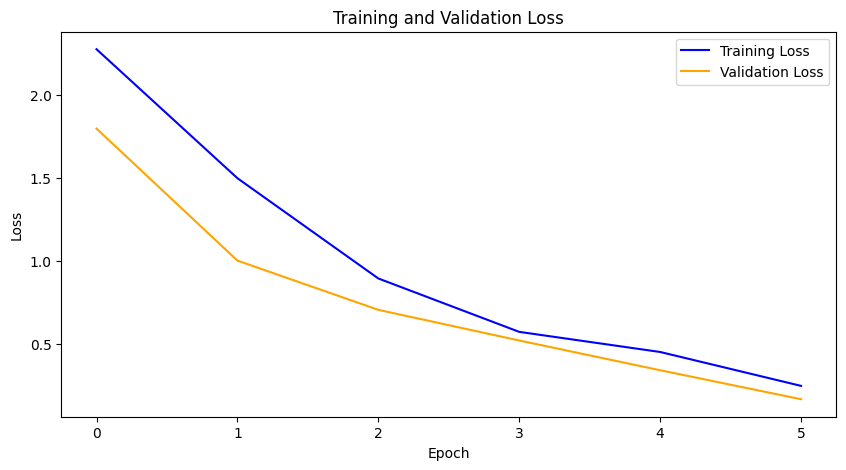

In [14]:
import matplotlib.pyplot as plt

# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Plot training accuracy , validation accuracy

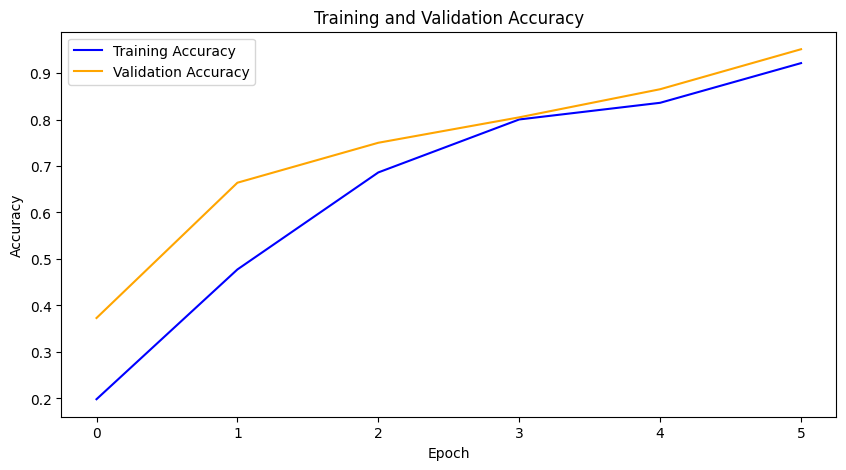

In [15]:
# Get training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Load the trained model

In [16]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ML Trained Models/Dtect_predictX.h5')

## Plot confusion matrix for validation dataset

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels for the validation dataset
true_labels = []
predicted_labels = []

for images, labels in val_ds:
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(model.predict(images), axis=1))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Plot confusion matrix for test dataset

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels and predicted labels for the validation dataset
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    true_labels.extend(np.argmax(labels, axis=1))
    predicted_labels.extend(np.argmax(model.predict(images), axis=1))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Making Predictions**

# From Testing dataset (test_ds)

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy().argmax()]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# For Unseen Data

### X-Prediction 01

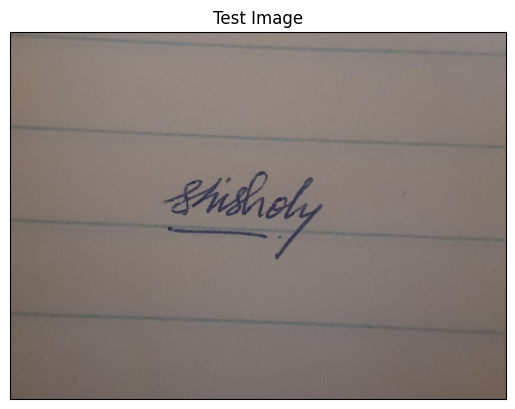

In [30]:
import cv2
image_path = '/content/drive/MyDrive/Kb_test.jpg'
# Reading an image in default mode
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [22]:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(256,256))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

print(predictions)

class_index = np.argmax(predictions)
class_name = f"Class {class_index} with {predictions[0][class_index] * 100:.2f}% accuracy"
class_name


1/1 [==============================] - 0s 72ms/step
[[4.9619535e-01 8.2606512e-06 1.2102343e-02 2.6939708e-06 3.1639374e-06
  2.7439702e-08 5.5931852e-04 2.9857889e-01 1.2534660e-03 1.9129661e-01]]


'Class 0 with 49.62% accuracy'

### X-Prediction 02

In [23]:
class_names = ['Person 1',
 'Person 10',
 'Person 2',
 'Person 3',
 'Person 4',
 'Person 5',
 'Person 6',
 'Person 7',
 'Person 8',
 'Person 9']

In [24]:
def predict_with_details(model, img, class_names):
    # Preprocess the image
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    print(predicted_class_index)
    print(predictions[0][predicted_class_index])
    print(class_names[predicted_class_index])

    # # Extract predicted class and confidence
    # predicted_class_index = np.argmax(predictions[0])
    # confidence = predictions[0][predicted_class_index]
    # predicted_class = class_names[predicted_class_index]

    # # Get the maximum value and its index
    # max_value = np.max(predictions)
    # max_index = np.argmax(predictions)

    # return predictions, max_value, max_index, confidence, predicted_class
    return None

In [34]:
# Load the sample image
sample_image_path = '/content/drive/MyDrive/orange2.jpeg'
img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(256, 256))

# Predict with details
predict_with_details(model, img, class_names)#
#predictions, max_value, max_index, confidence, predicted_class = predict_with_details(model, img, class_names)

# # Print the results
# print("Predictions Matrix:")
# print(predictions)
# print("Maximum Value of Predictions:", max_value)
# print("Index of Maximum Value:", max_index)
# print("Confidence:", confidence)
# print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 157ms/step
3
0.8442328
Person 3


### X-Prediction 03

In [ ]:
class_dict = {
    0: 'Person1',
    1: 'Person10',
    2: 'Person2',
    3: 'Person3',
    4: 'Person4',
    5: 'Person5',
    6: 'Person6',
    7: 'Person7',
    8: 'Person8',
    9: 'Person9',
}

In [ ]:
import numpy as np

def predict_with_details(model, img, class_dict):
    # Preprocess the image
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model.predict(img_array)

    # Extract predicted class and confidence
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index]
    predicted_class = class_dict[predicted_class_index]

    # Get the maximum value and its index
    max_value = np.max(predictions)
    max_index = np.argmax(predictions)

    return predictions, max_value, max_index, confidence, predicted_class

In [ ]:
# Load the sample image
sample_image_path = '/content/drive/MyDrive/Dataset/DTect Testing/Person 2/WhatsApp Image 2024-03-02 at 20.53.01_3830da89.jpg'
img = tf.keras.preprocessing.image.load_img(sample_image_path, target_size=(256, 256))

# Predict with details
predictions, max_value, max_index, confidence, predicted_class = predict_with_details(model, img, class_dict)

# Print the results
print("Predictions Matrix:")
print(predictions)
print("Maximum Value of Predictions:", max_value)
print("Index of Maximum Value:", max_index)
print("Confidence:", confidence)
print("Confidence Percentage: {:.2f}%".format(confidence * 100))
print("Predicted Class:", predicted_class)